# Eye for Blind

In [1]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing

### Importing required libraries

In [2]:
pip show keras

Name: keras
Version: 2.7.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: tensorflow
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import all the required libraries
import glob
from PIL import Image
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

# from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam, RMSprop

import warnings
warnings.filterwarnings("ignore")

## Let's read the dataset

## Data Understanding
1. Load the dataset and store images and captions in separate variables.
2. Visualize the images and text found in the dataset.
3. Build mappings for word-to-index and index-to-word.
4. Construct a dataframe summarizing images, paths, and captions.
5. Generate a visualization of the most frequent 30 words in the captions.
6. Compile a list containing all captions along with their respective paths.

In [5]:
#Import the dataset and read the image into a seperate variable

import glob

image_folder = '/home/Eye_for_Blind/Flickr8K/Images/'

# Note the '/' added after the folder path to ensure correct path formation
all_imgs = glob.glob(image_folder + '*.jpg', recursive=True)

print("The total images present in the dataset: {}".format(len(all_imgs)))


The total images present in the dataset: 8091


### Display both the images and the text contained in the dataset.

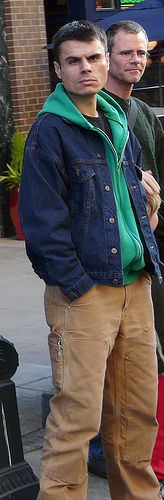

In [6]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[0])

In [7]:
all_imgs[0]

'/home/Eye_for_Blind/Flickr8K/Images/3039209547_81cc93fbec.jpg'

### Generate mappings that associate words with their corresponding indices and indices with their corresponding words.

In [8]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    text=open(filename).read()
    
    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(image_folder+'/'+im_id)
    return keys,values,key_paths

text_file='/home/Eye_for_Blind/Flickr8K/captions.txt'

doc = load_doc(text_file)
print(doc[:600], "........")

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7 ........


### Construct a dataframe that provides a concise overview of images, their file paths, and associated captions.

Generate a dataframe that provides a comprehensive summary of the images, their file paths, and associated captions. The dataset should consist of a total of 40,455 samples, each with five captions linked to its corresponding image ID.

In [9]:
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)#store all the image id here


df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/home/Eye_for_Blind/Flickr8K/Images//100026820...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/home/Eye_for_Blind/Flickr8K/Images//100026820...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/home/Eye_for_Blind/Flickr8K/Images//100026820...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/home/Eye_for_Blind/Flickr8K/Images//100026820...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/home/Eye_for_Blind/Flickr8K/Images//100026820...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/home/Eye_for_Blind/Flickr8K/Images//997722733...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/home/Eye_for_Blind/Flickr8K/Images//997722733...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/home/Eye_for_Blind/Flickr8K/Images//997722733...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/home/Eye_for_Blind/Flickr8K/Images//997722733...,A rock climber in a red shirt .


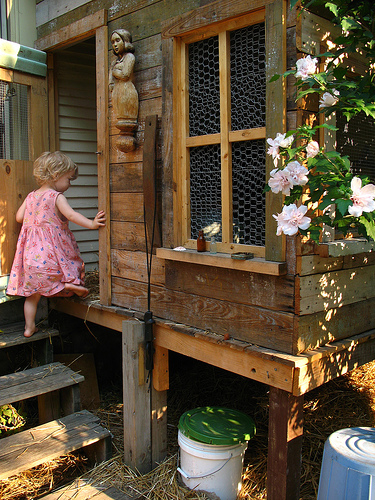

In [10]:
Image.open(all_img_vector[0])

In [11]:
#Create the vocabulary & the counter for the captions
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

### Produce a visualization showcasing the 30 most frequently occurring words in the captions

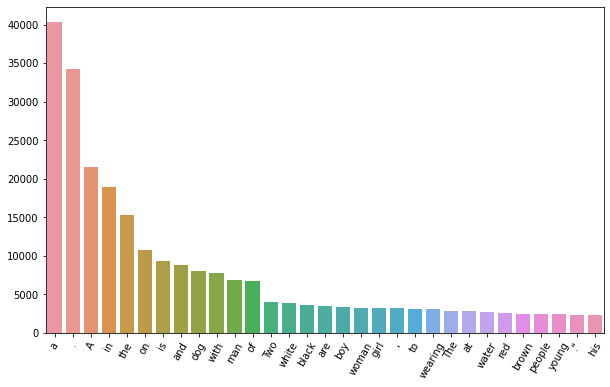

In [12]:
#Visualise the top 30 occuring words in the captions
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

### Formulate a list that encompasses all captions along with their respective file paths

In [13]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

#add the <start> & <end> token to all those captions as well


#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


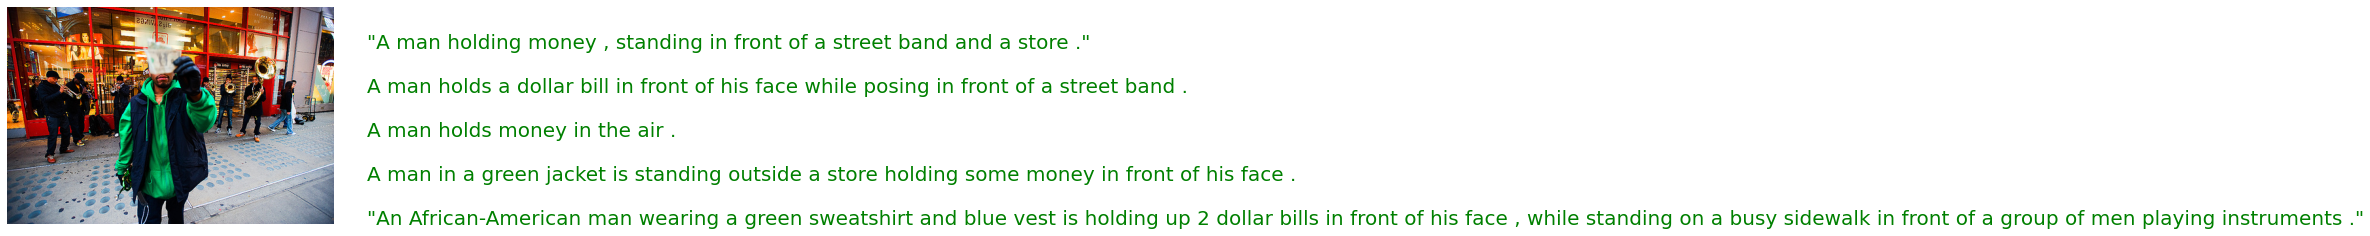

In [14]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='green')
caption_and_image_plotter(df.ID.iloc[8049],df)

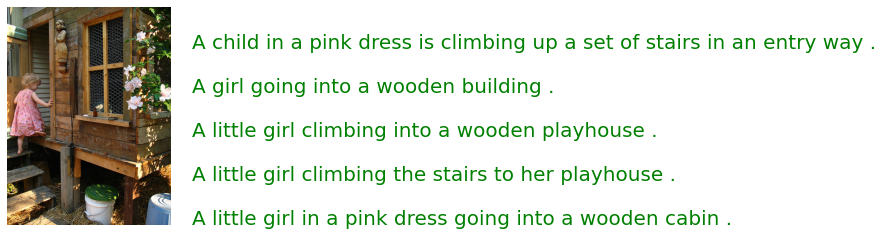

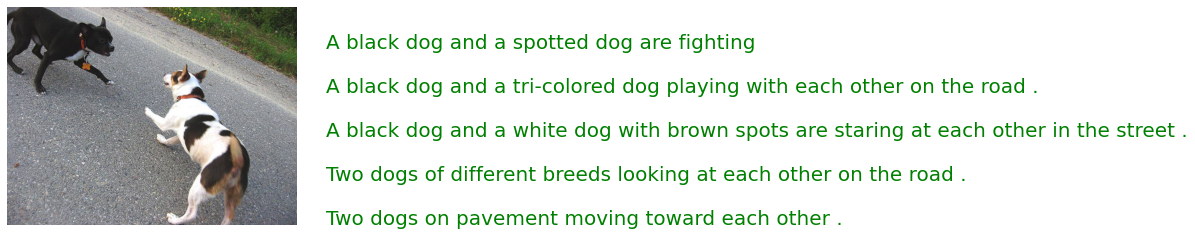

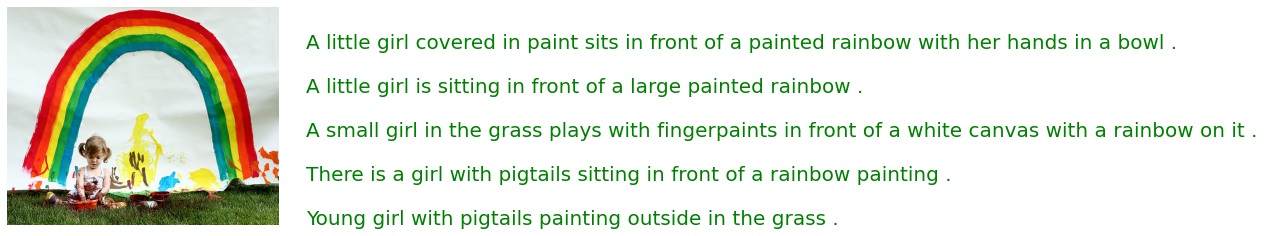

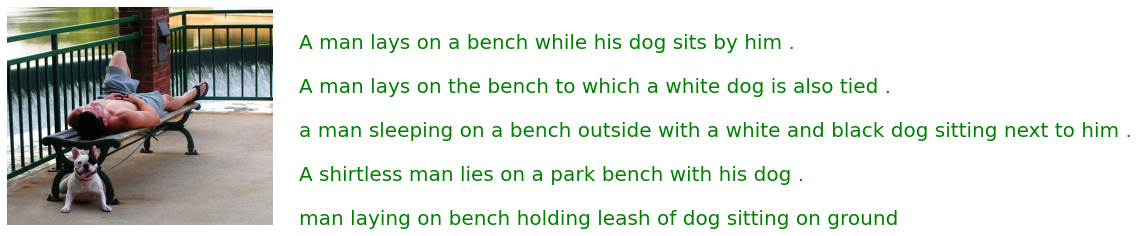

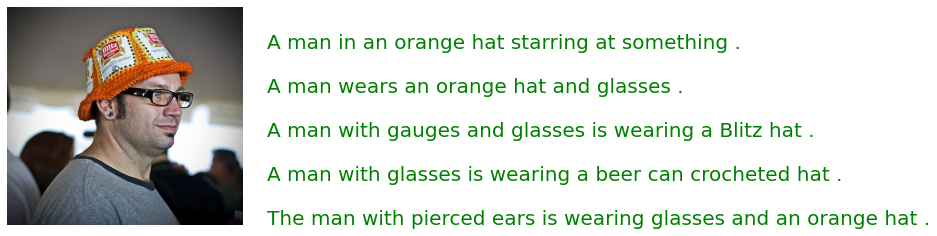

In [15]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,5,df)

## Pre-Processing the captions

1. Generate tokenized vectors by splitting the captions using spaces and applying additional filters. This process results in a vocabulary containing all unique words within the data. To conserve memory, limit the total vocabulary size to the top 5,000 words.

2. Subsitute all other words with the "UNK" token, representing unknown terms.

3. Establish mappings for word-to-index and index-to-word.

4. Uniformly extend all sequences to match the length of the longest sequence through padding.

In [16]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [17]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [18]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [19]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

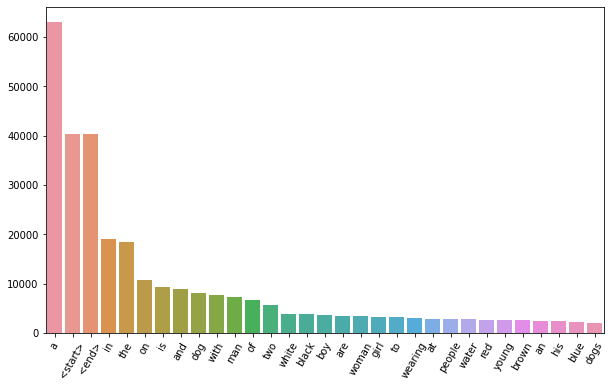

In [20]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [21]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(train_seqs)

In [22]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_l)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1. Reshape the images to dimensions of (299, 299).

2. Normalize the images to fall within the range of -1 to 1. This adjustment ensures the images are appropriately formatted for compatibility with the InceptionV3 model.

In [23]:
#write your code here
def load_the_image(file_path):
    my_img = tf.io.read_file(file_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,file_path

2023-08-23 16:45:52.160000: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-23 16:45:52.160075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


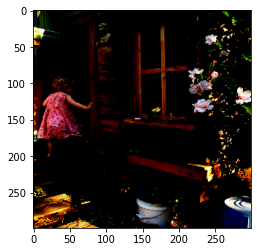

In [24]:
plt.imshow(load_the_image(all_img_path[0])[0])

In [25]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [26]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Generate the training and testing datasets.

1. Utilize the tf.data.Dataset API to merge both images and captions, forming the training and testing datasets. Create the train-test split with an 80-20 ratio and a fixed random state of 42.

2. Ensure that shuffling and batching are applied during the dataset construction.

3. After assembling the dataset, confirm that each image's shape is (batch_size, 299, 299, 3).

4. After dataset creation, verify that each caption's shape is (batch_size, max_len), where max_len represents the maximum length of a caption.

In [27]:
#write your code here
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=33)

In [28]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [29]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

## Import the pre-trained ImageNet weights for the InceptionNetV3 model.

1. To prevent excessive memory consumption, extract image features using the final layer of the pre-trained model. Including this process in training could result in extended computational time.

2. The output shape of this layer is 8x8x2048.

3. Employ a function to extract features from each image within the train and test datasets, resulting in an image shape of (batch_size, 8x8, 2048).

In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = keras.Model(new_input, hidden_layer) 

87924736/87910968 [==============================] - 6s 0us/step


In [31]:
# write your code to extract features from each image in the dataset
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [32]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [00:37<00:00,  6.79it/s]


In [33]:
batch_f.shape

TensorShape([64, 2048])

In [34]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [35]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [36]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building

1. Define the parameters.

2. Construct the Encoder, Attention model, and Decoder components.

In [37]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [38]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [39]:
encoder=Encoder(embedding_dim)

### Attention model

In [40]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

In [41]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Decoder

In [42]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [44]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization

1. Configure the optimizer and create the loss object.

2. Establish the checkpoint path.

3. Develop functions for both training and testing steps.

4. Formulate the loss function for the test dataset.

In [45]:
optimizer = tf.keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [46]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [47]:
checkpoint_path = "flickr8k/File4/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

In [48]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [49]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [50]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [51]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [52]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.198, & test loss is 1.004
Time taken for 1 epoch 260.18426990509033 sec

Test loss has been reduced from 100.000 to 1.004


  7%|▋         | 1/15 [04:20<1:00:45, 260.39s/it]

For epoch: 2, the train loss is 0.941, & test loss is 0.890
Time taken for 1 epoch 121.0672287940979 sec

Test loss has been reduced from 1.004 to 0.890


 13%|█▎        | 2/15 [06:21<38:42, 178.62s/it]  

For epoch: 3, the train loss is 0.856, & test loss is 0.820
Time taken for 1 epoch 114.99123072624207 sec

Test loss has been reduced from 0.890 to 0.820


 27%|██▋       | 4/15 [10:11<24:52, 135.67s/it]

For epoch: 4, the train loss is 0.795, & test loss is 0.765
Time taken for 1 epoch 114.0443902015686 sec

Test loss has been reduced from 0.820 to 0.765
For epoch: 5, the train loss is 0.744, & test loss is 0.718
Time taken for 1 epoch 112.50527167320251 sec

Test loss has been reduced from 0.765 to 0.718


 40%|████      | 6/15 [13:56<18:21, 122.34s/it]

For epoch: 6, the train loss is 0.699, & test loss is 0.676
Time taken for 1 epoch 112.34202027320862 sec

Test loss has been reduced from 0.718 to 0.676


 47%|████▋     | 7/15 [15:48<15:51, 118.98s/it]

For epoch: 7, the train loss is 0.661, & test loss is 0.639
Time taken for 1 epoch 111.86099171638489 sec

Test loss has been reduced from 0.676 to 0.639
For epoch: 8, the train loss is 0.624, & test loss is 0.603
Time taken for 1 epoch 111.68794560432434 sec

Test loss has been reduced from 0.639 to 0.603


 60%|██████    | 9/15 [19:31<11:30, 115.08s/it]

For epoch: 9, the train loss is 0.590, & test loss is 0.572
Time taken for 1 epoch 111.27729845046997 sec

Test loss has been reduced from 0.603 to 0.572
For epoch: 10, the train loss is 0.562, & test loss is 0.543
Time taken for 1 epoch 112.55592083930969 sec

Test loss has been reduced from 0.572 to 0.543


 67%|██████▋   | 10/15 [21:24<09:31, 114.37s/it]

For epoch: 11, the train loss is 0.534, & test loss is 0.518
Time taken for 1 epoch 112.27266573905945 sec

Test loss has been reduced from 0.543 to 0.518


 80%|████████  | 12/15 [25:10<05:40, 113.53s/it]

For epoch: 12, the train loss is 0.509, & test loss is 0.494
Time taken for 1 epoch 112.72765588760376 sec

Test loss has been reduced from 0.518 to 0.494


 87%|████████▋ | 13/15 [27:02<03:46, 113.34s/it]

For epoch: 13, the train loss is 0.486, & test loss is 0.474
Time taken for 1 epoch 112.71606135368347 sec

Test loss has been reduced from 0.494 to 0.474


 93%|█████████▎| 14/15 [28:55<01:53, 113.13s/it]

For epoch: 14, the train loss is 0.465, & test loss is 0.453
Time taken for 1 epoch 112.46691608428955 sec

Test loss has been reduced from 0.474 to 0.453
For epoch: 15, the train loss is 0.448, & test loss is 0.437
Time taken for 1 epoch 112.19965291023254 sec

Test loss has been reduced from 0.453 to 0.437


100%|██████████| 15/15 [30:48<00:00, 123.20s/it]


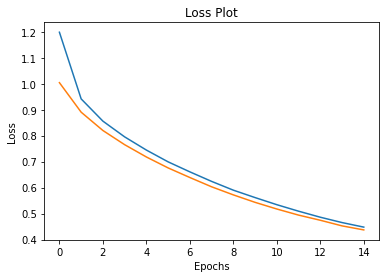

In [53]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation

1. Create an evaluation function utilizing the greedy search strategy.

2. Create an alternative evaluation function utilizing beam search (optional).

3. Evaluate the model's performance on sample data using the BLEU score metric.

### Greedy Search

In [54]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [55]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [56]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [57]:
from nltk.translate.bleu_score import sentence_bleu

In [58]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [59]:
import numpy as np

In [60]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

7799
BLEU score: 70.17
Real Caption: a group of amish people are standing outside of a church
Prediction Caption: a group of amish people are gathered outside of a church


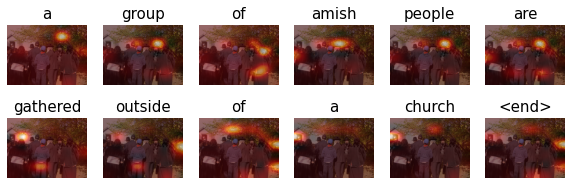

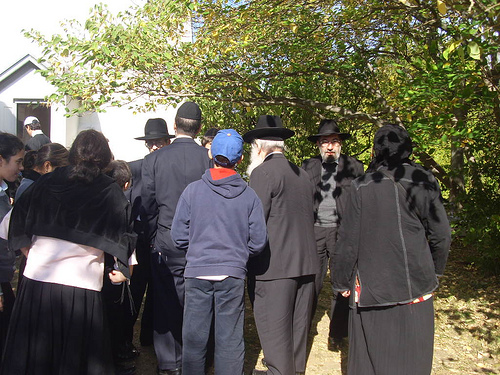

In [71]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

rid = np.random.randint(0, len(image_test))
print(rid)
test_image = image_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

# Use a smoothing function to avoid zero division and improve BLEU calculation
smoothie = SmoothingFunction().method4

# Calculate BLEU score
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) * 100
print(f"BLEU score: {score:.2f}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [72]:
captions=beam_evaluate(test_image)
print(pred_caption)

a group of amish people are gathered outside of a church
